<div class="alert alert-block alert-success">
    <h1 align="center">Missing Values (Imputation) in a Nutshell</h1>
    <h3 align="center">PreProcessing before Training model</h3>
    <h4 align="center"><a href="http://www.iran-machinelearning.ir">Soheil Tehranipour</a></h5>
</div>

# Introduction

Missing values is one of the most common problems that you will come across when performing data analysis. Furthermore, machine learning models require that a dataset does not contain any missing values before they can be fitted to the data. Therefore, it is crucial that we learn how to properly handle them.

There are mainly two ways that we can deal with missing values in a dataset:

1. If there are only a few rows with missing values or if a column has an overwhelming number of missing values, we can simply drop them from the dataset without running into the risk of losing too much information. 
2. An alternative approach to handling missing values is via imputation. Imputation is the process whereby the missing values in a dataset are replaced with some substituted values. 

For the purpose of this tutorial, we will examine the process of imputation and more specifically, we will learn the difference between a univariate approach to imputing versus a multivariate approach to imputing. 

Univariate imputation implies that we are only considering the values of a single column when performing imputation. Multivariate imputation, on the other hand, involves taking into account other features in the dataset when performing imputation.

The multivariate approach to imputing is generally preferred over the univariate approach as it is more robust and provides our model with a more accurate representation of the missing values in order to make better predictions.

In this tutorial, we will explore 3 different imputation techniques with reference to the [Titanic dataset](https://www.kaggle.com/c/titanic/data) on Kaggle:

- [Simple imputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)
- [Iterative imputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer)
- [KNN Imputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)

# 1. Import libraries

In [2]:
# Data wrangling
import pandas as pd
import numpy as np 

# Data visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# 2. Prepare dataset

# 2.1 Import and read data

In [3]:
data = pd.read_csv(r"C:\Users\soso\Desktop\Maktbakhoone\Scikit-Learn Tips\00 -  Missing Value/train.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 2.2 Drop unwanted columns 

For the purpose of this tutorial, I proceeded to drop the PassengerId, Name, Ticket and Cabin columns from the original dataset. 

In [7]:
# Drop PassengerId, Name, Ticket and Cabin columns 

data = data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


# 2.3 Drop rows with missing Embarked values

In [8]:
# Missing data

missing = data.isnull().sum()
missing = missing[missing > 0].sort_values(ascending = False)
missing

Age         177
Embarked      2
dtype: int64

Because there are only two rows with missing Embarked values, I decided to simply drop those two rows from the dataset, leaving us with 177 rows with missing Age values. 

In [9]:
# Drop rows with missing Embarked values 

print("Before: ", data.shape)
data = data.loc[data['Embarked'].notnull(), :]
print("After: ", data.shape)

Before:  (891, 8)
After:  (889, 8)


In [10]:
# Check missing values again

missing = data.isnull().sum()
missing[missing > 0]

Age    177
dtype: int64

# 3. Explore Age feature

Before we perform imputation on the Age column, let's briefly explore the Age feature. 

Text(0.5, 1.0, 'Correlation between features')

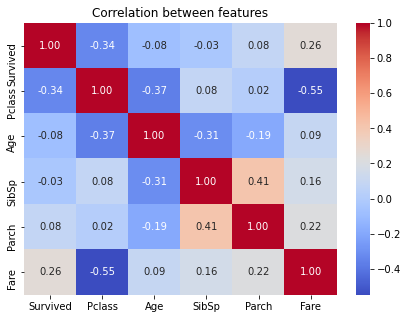

In [11]:
# Plot heatmap 

correlation = data.corr()
plt.figure(figsize = (7, 5))
sns.heatmap(correlation, annot = True, fmt = '.2f', cmap = 'coolwarm')
plt.title('Correlation between features')

In [12]:
# Age correlation with other features 

correlation['Age'].sort_values(ascending = False)[1:]

Fare        0.093143
Survived   -0.082446
Parch      -0.187896
SibSp      -0.307351
Pclass     -0.365902
Name: Age, dtype: float64

As we can see, the Age feature is slightly positively correlated with the Fare feature. In other words, passengers that are older generally pay a higher fare. 

Text(0.5, 1.0, 'Passenger Age Distribution')

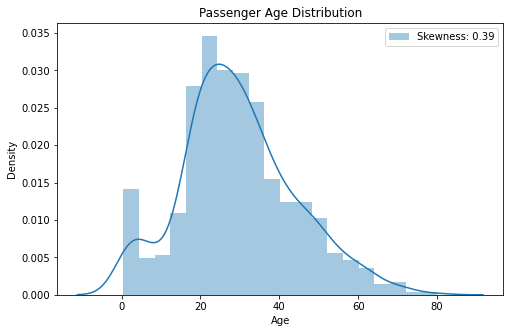

In [13]:
# Plot passenger age distribution

plt.figure(figsize = (8, 5))
sns.distplot(data['Age'], label = 'Skewness: {:.2f}'.format(data['Age'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Age Distribution')

In [14]:
# Age summary statistics 

data['Age'].describe()

count    712.000000
mean      29.642093
std       14.492933
min        0.420000
25%       20.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

# 4. Missing values imputation

In this section, we will look at 3 different imputation techniques:

1. Simple imputer
2. Iterative imputer
3. KNN Imputer

Here, I have created a sample dataframe to demonstrate the differences between the 3 techniques. 

In [15]:
# Create sample dataframe

df = pd.DataFrame({'SibSp': [1, 1, 0, 1, 0, 0], 
                   'Fare': [7.25, 71.2833, 7.925, 53.1, 8.05, 8.4583], 
                   'Age': [22, 38, 26, 35, 35, np.nan]})
df

,SibSp,Fare,Age
0,1,7.2500,22.0
1,1,71.2833,38.0
2,0,7.9250,26.0
3,1,53.1000,35.0
4,0,8.0500,35.0
5,0,8.4583,NaN


# 4.1 Simple imputer

Simple imputer follows a univariate approach to imputing missing values i.e. it only takes a single feature into consideration. Some of the most common uses of simple imputer are:

- Mean
- Median
- Most frequent (mode)

In [16]:
print("Average age: ", df['Age'].mean())
simple_imp = SimpleImputer(missing_values = np.nan, strategy = 'mean')
simple_imp.fit_transform(df)

Average age:  31.2


array([[ 1.    ,  7.25  , 22.    ],
       [ 1.    , 71.2833, 38.    ],
       [ 0.    ,  7.925 , 26.    ],
       [ 1.    , 53.1   , 35.    ],
       [ 0.    ,  8.05  , 35.    ],
       [ 0.    ,  8.4583, 31.2   ]])

As we can see, simple imputer has filled the missing value in the Age column with the average age which is 31.2.

# 4.2 Iterative imputer

Iterative imputer is an example of a multivariate approach to imputation. It models the missing values in a column by using information from the other columns in a dataset. More specifically, it treats the column with missing values as a target variable while the remaining columns are used are predictor variables to predict the target variable. 

In our sample data frame, the Age column has one missing value on row 6 and is therefore assigned as the target variable in this scenario. This leaves the SibSp and Fare columns as our predictor variables. 

Iterative imputer will use the first 5 rows of the data frame to train a predictive model. Once the model is ready, it will then values in the SibSp and Fare columns of row 6 as inputs and predict the Age value for that row.

#### It is a data transform that is first configured based on the method used to estimate the missing values. By default, a BayesianRidge model is employed that uses a function of all other input features. Features are filled in ascending order, from those with the fewest missing values to those with the most.



In [17]:
iterative_imp = IterativeImputer()
iterative_imp.fit_transform(df)

array([[ 1.        ,  7.25      , 22.        ],
       [ 1.        , 71.2833    , 38.        ],
       [ 0.        ,  7.925     , 26.        ],
       [ 1.        , 53.1       , 35.        ],
       [ 0.        ,  8.05      , 35.        ],
       [ 0.        ,  8.4583    , 28.50639495]])

As we can see, the value predicted under iterative imputer is different to that under simple imputer.

This is a more accurate approach to predict the missing Age value as it takes other features in our dataframe into account. 

# 4.3 KNN imputer

Last but not least, we have KNN Imputer which is another multivariate imputation technique. KNN Imputer scans our dataframe for k nearest observations to the row with missing value. It will then proceed to fill the missing value with the average of those nearest observations. 

Here, I have set k to equal to 2 or in other words, I want KNN imputer to look for 2 observations that are nearest to row 6 and fill the missing age with the average age of those 2 rows.

In [18]:
knn_imp = KNNImputer(n_neighbors = 2)
knn_imp.fit_transform(df)

array([[ 1.    ,  7.25  , 22.    ],
       [ 1.    , 71.2833, 38.    ],
       [ 0.    ,  7.925 , 26.    ],
       [ 1.    , 53.1   , 35.    ],
       [ 0.    ,  8.05  , 35.    ],
       [ 0.    ,  8.4583, 30.5   ]])

As a result, KNN imputer has taken row 3 and row 5 as the nearest observations for row 6.

Therefore, the average age between row 3 and row 5 is (26 + 35) / 2 = 30.5. 

# 5. Model accuracy under simple imputer and iterative imputer

Now that we have a better understanding of how the different imputers work, we can move on to apply these techniques to our Titanic dataset and compare the model accuracy under each approach.

We should expect to see our model perform better under multivariate imputation than univariate imputation as multivariate imputation provides a more accurate prediction of the missing values and thus allowing our model to make better predictions. 

In this section, we will build a column transformer which consists of a OneHotEncoder for encoding the Sex and Embarked columns as well as an imputer to impute the missing values in the Age column.

Following that, we will chain the column transformer with a random forest classifier to predict the surival of the passengers on the Titanic. Finally, we will perform 10-fold cross-validation to compare the prediction results under univariate imputation versus under multivariate imputation. 

In [19]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [20]:
# Get predictor and target variables 

X = data.drop('Survived', axis = 1)
Y = data['Survived']

In [21]:
# Predictor and target variables shape

print("X shape: ", X.shape)
print("Y shape: ", Y.shape)

X shape:  (889, 7)
Y shape:  (889,)


# 5.1 Univariate imputation (simple imputer)

In [22]:
# Instantiate OneHotEncoder for Sex and Embarked columns
ohe = OneHotEncoder()

# Instantiate simple imputer 
simple_imp = SimpleImputer(missing_values = np.nan, strategy = 'mean')

# Instantiate model
rf = RandomForestClassifier()

# Make column transformer with simple imputer
column_transform = make_column_transformer(
    (ohe, ['Sex', 'Embarked']),
    (simple_imp, ['Age']),
    remainder = 'passthrough')

# Pipeline
pipe = make_pipeline(column_transform, rf)

# 10-fold cross-validation
cross_val_score(pipe, X, Y, cv = 10, scoring = 'accuracy').mean()

0.8087972420837589

# 5.2 Multivariate imputation (iterative imputer)

In [23]:
# Instantiate OneHotEncoder for Sex and Embarked columns
ohe = OneHotEncoder()

# Instantiate iterative imputer
iterative_imp = IterativeImputer()

# Instantiate model
rf = RandomForestClassifier()

# Make column transformer with iterative imputer
column_transform = make_column_transformer(
    (ohe, ['Sex', 'Embarked']),
    (iterative_imp, ['Age']),
    remainder = 'passthrough')

# Pipeline
pipe = make_pipeline(column_transform, rf)

# 10-fold cross-validation 
cross_val_score(pipe, X, Y, cv = 10, scoring = 'accuracy').mean()

0.807673646578141

Although not a drastic difference, we can conclude that our model performed better under multivariate imputation as it achieved a higher mean cross-validation score.

# 6. Conclusion

In this tutorial, we have learned the difference between univariate imputation and multivariate imputation. In addition, We also looked at 3 different imputation techniques within Scikit-learn which include simple imputer, iterative imputer and KNN imputer. 

After comparing the prediction accuracy of our model using simple imputer versus iterative imputer, we can conclude that multivariate imputation results in better model predictions due to its lower mean cross-validation score.

# 7. References

- [Scikit-learn imputation of missing values](https://scikit-learn.org/stable/modules/impute.html)
- [Impute missing values using KNNImputer and IterativeImputer](https://www.youtube.com/watch?v=m_qKhnaYZlc)

<img src="https://webna.ir/wp-content/uploads/2018/08/%D9%85%DA%A9%D8%AA%D8%A8-%D8%AE%D9%88%D9%86%D9%87.png" width=50% />